# A comparative study of clustering methods for hyperspectral data processing

### Ehsan Farahbakhsh<sup>1</sup>, Pulkit Sharma<sup>2</sup>, Aman Agrawal<sup>3</sup>, Rohitash Chandra<sup>4</sup>

<sup>1</sup>*EarthByte Group, School of Geosciences, The University of Sydney, Sydney, Australia*

<sup>2</sup>*JECRC University, Jaipur, Rajasthan, India*

<sup>3</sup>*Indian Institute of Technology, Kanpur, Kanpur, India*

<sup>4</sup>*Transitional Artificial Intelligence Research Group, School of Mathematics and Statistics, University of New South Wales, Sydney, Australia*

This notebook enables the user to apply different clustering algorithms to the Indian Pines dataset. Different types of plots can be generated in addition to calculating various performance metrics to compare the efficiency of the algorithms in creating accurate clustered maps.

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

from ds_utils.unsupervised import plot_cluster_cardinality
from ipywidgets import interact
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

from sklearn import cluster, mixture
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, completeness_score, homogeneity_score, mutual_info_score, rand_score, v_measure_score
from sklearn.preprocessing import minmax_scale
from skopt import BayesSearchCV
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

### Loading and visualising the dataset

In [2]:
# import the data
data_array = loadmat('./Indian_pines_corrected.mat')['indian_pines_corrected'] # hyperspectral data
gt = loadmat('./Indian_pines_gt.mat')['indian_pines_gt'] # ground truth data

In [3]:
# read and enhance hyperspectral data
def plot_array_stretched(array, label, n):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.axis('off')
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    cb = plt.imshow(array, cmap='Greys_r', vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    plt.colorbar(cb, shrink=1, label=label)
    plt.show()

@interact(band=range(1, data_array.shape[2]+1))
def show_dist(band):
    plot_array_stretched(data_array[:, :, band-1], f'Band {band}', 2)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

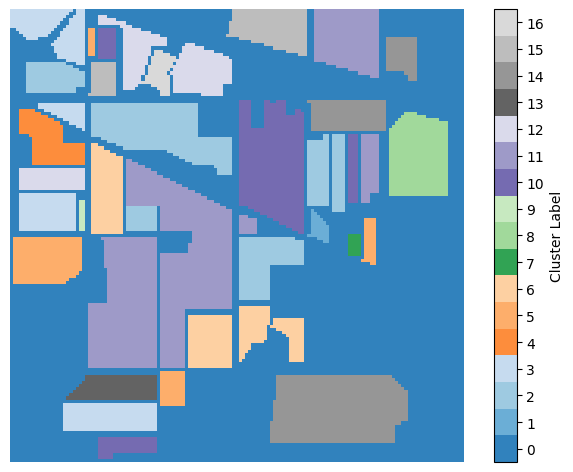

In [4]:
# plot ground truth data
def plot_data(data, n_clusters):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.axis('off')
    cmap = cm.get_cmap('tab20c', n_clusters)
    plt.imshow(data, cmap=cmap)
    cbar = plt.colorbar(label='Cluster Label')
    tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(n_clusters))
    plt.show()

plot_data(gt, 17)

In [5]:
# reshape the input data from rcb to samples and features
data_reshaped = data_array.reshape(data_array.shape[0]*data_array.shape[1], -1)
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
gt_reshaped = gt.flatten()

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [6]:
# t-SNE
tsne = TSNE(perplexity=50, learning_rate=389, random_state=1, n_jobs=-1)
selected_components = tsne.fit_transform(data_reshaped)

# K-means

In [ ]:
# k-means clustering using the components generated in the previous cell
k_means = cluster.KMeans(n_clusters=17, random_state=1) # create an object of the classifier

search_space = {
    'max_iter': Integer(100, 300),
    'tol': Real(0.0001, 0.01)
    }

bayes_search = BayesSearchCV(k_means, search_space, n_iter=50, # specify how many iterations
                             scoring='v_measure_score', n_jobs=-1, verbose=1, random_state=1)

bayes_search.fit(selected_components, gt_reshaped) # callback=on_step will print score after each iteration

print('\n', bayes_search.best_estimator_)
print('\nBest V-measure:', bayes_search.best_score_)

# Best V-measure: 0.32700212548207463
# max_iter=230, tol=0.0010575184942044017

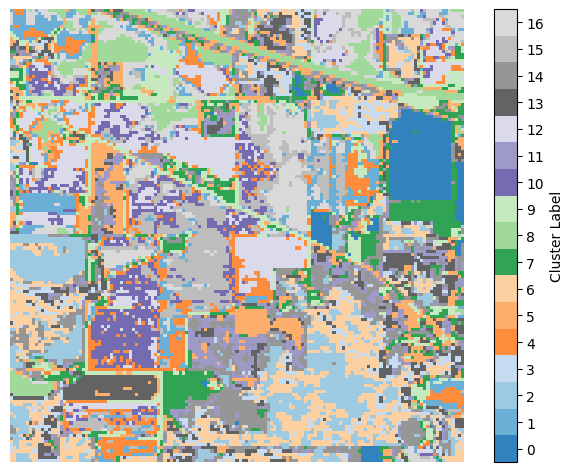

In [7]:
# k-means clustering using the selected components
k_means = cluster.KMeans(n_clusters=17, max_iter=230, tol=0.001, random_state=1) # create an object of the classifier
labels = k_means.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

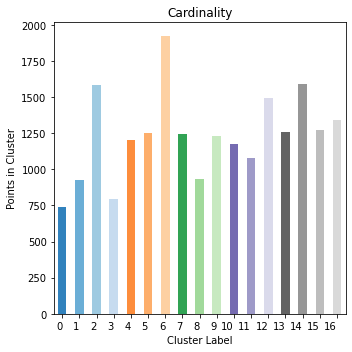

In [8]:
n_clusters = 16
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(k_means.labels_, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

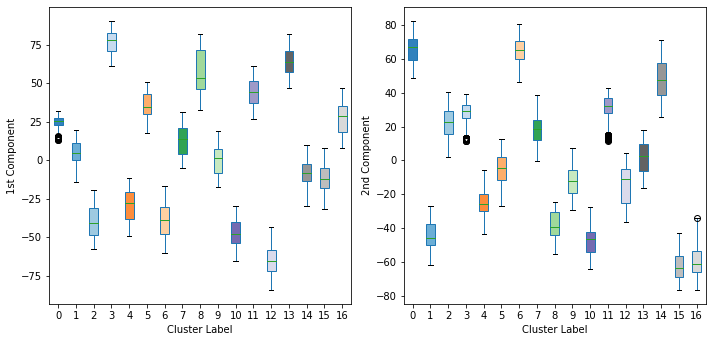

In [9]:
features = ['1st Component', '2nd Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = k_means.labels_

ncols = 2
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = selected_components_df[[feature, 'cluster']].boxplot(by='cluster', ax=ax, return_type='both', patch_artist=True)

    for row_key, (ax, row) in box.iteritems():
        ax.set_xlabel('Cluster Label')
        ax.set_title('')
        ax.set_ylabel(feature)
        ax.grid(False)
        
        for i, box_ in enumerate(row['boxes']):
            box_.set_facecolor(colors[i])

fig.suptitle('')
plt.tight_layout()
plt.show()

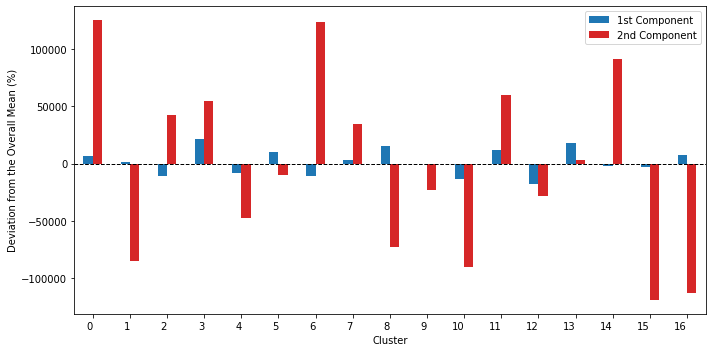

In [10]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_pca = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.KMeans(n_clusters=n_clusters, max_iter=230, tol=0.001, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_pca.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_pca.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.430871,26090.861499,0.748643,0.368591,0.250862,0.298539,0.701155,0.068545,0.673328,0.296823
16.0,0.435808,27332.454997,0.715798,0.383168,0.254373,0.305761,0.701840,0.065040,0.699957,0.303966
17.0,0.435094,27046.167058,0.724229,0.383581,0.249784,0.302550,0.702769,0.064401,0.700711,0.300647
18.0,0.427045,27489.247818,0.735978,0.382645,0.244586,0.298422,0.700950,0.054502,0.699000,0.296409
19.0,0.433446,27886.269532,0.714303,0.388422,0.244068,0.299772,0.701953,0.054399,0.709555,0.297667


# MiniBatch K-means

In [ ]:
# minibatch k-means clustering using the slected components
minibatch_kmeans = cluster.MiniBatchKMeans(n_clusters=17, random_state=1) # create an object of the classifier

search_space = {
    'max_iter': Integer(50, 150),
    'batch_size': Integer(512, 2048)
    }

bayes_search = BayesSearchCV(minibatch_kmeans, search_space, n_iter=50, # specify how many iterations
                                scoring='v_measure_score', n_jobs=-1, verbose=1, random_state=1)

bayes_search.fit(selected_components, gt_reshaped) # callback=on_step will print score after each iteration

print('\n', bayes_search.best_estimator_)
print('\nBest V-measure:', bayes_search.best_score_)

# Best V-measure: 0.33262653416916943
# batch_size=1282, max_iter=150

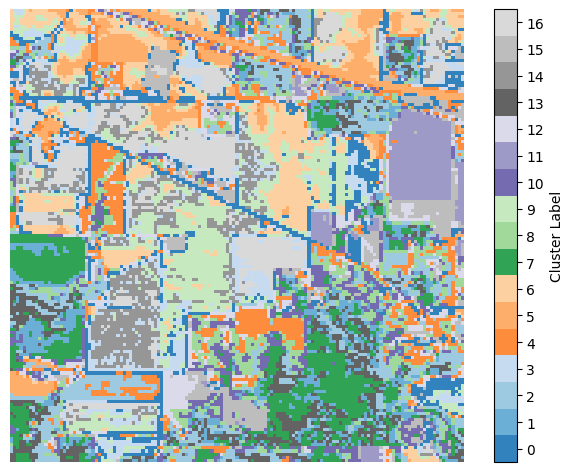

In [12]:
# minibatch k-means clustering using the selected components
minibatch_kmeans = cluster.MiniBatchKMeans(n_clusters=17, max_iter=150, batch_size=1282, random_state=1) # create an object of the classifier
labels = minibatch_kmeans.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

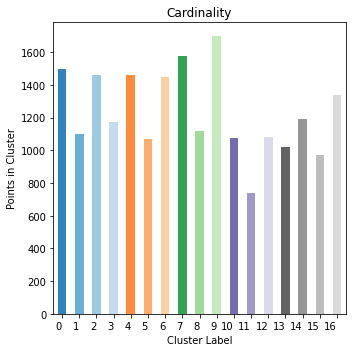

In [13]:
n_clusters = 16
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(minibatch_kmeans.labels_, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

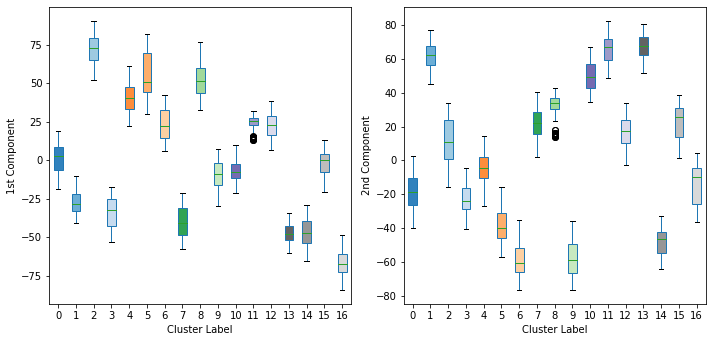

In [14]:
features = ['1st Component', '2nd Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = minibatch_kmeans.labels_

ncols = 2
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = selected_components_df[[feature, 'cluster']].boxplot(by='cluster', ax=ax, return_type='both', patch_artist=True)

    for row_key, (ax, row) in box.iteritems():
        ax.set_xlabel('Cluster Label')
        ax.set_title('')
        ax.set_ylabel(feature)
        ax.grid(False)
        
        for i, box_ in enumerate(row['boxes']):
            box_.set_facecolor(colors[i])

fig.suptitle('')
plt.tight_layout()
plt.show()

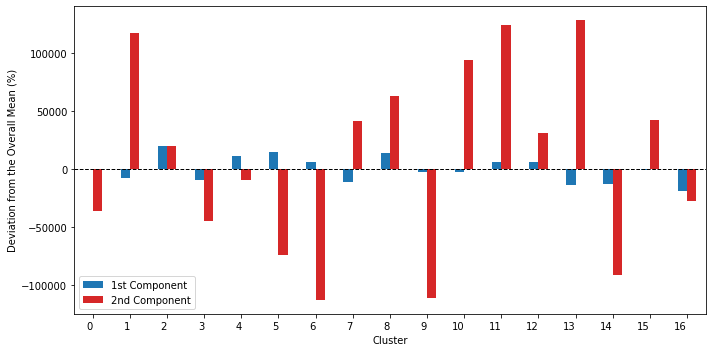

In [15]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_minibatch_kmeans = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.MiniBatchKMeans(n_clusters=n_clusters, max_iter=150, batch_size=1282, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_minibatch_kmeans.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_minibatch_kmeans.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.409632,25160.025534,0.765449,0.365429,0.248660,0.295942,0.698205,0.059320,0.667551,0.294220
16.0,0.436189,27059.870562,0.706826,0.374716,0.249242,0.299363,0.700158,0.060485,0.684518,0.297550
17.0,0.410561,25391.274908,0.784157,0.371982,0.241557,0.292907,0.699804,0.053890,0.679522,0.290980
18.0,0.410810,25643.003191,0.806948,0.387987,0.247192,0.301985,0.705107,0.066706,0.708760,0.299986
19.0,0.400823,26221.549187,0.806618,0.386935,0.241284,0.297225,0.702467,0.053701,0.706839,0.295119


# Bisecting K-means

In [ ]:
# bisecting k-means clustering using the selected components
bisecting_kmeans = cluster.BisectingKMeans(n_clusters=17, random_state=1) # create an object of the classifier

search_space = {
    'max_iter': Integer(100, 300),
    'bisecting_strategy': Categorical(['biggest_inertia', 'largest_cluster'])
    }

bayes_search = BayesSearchCV(bisecting_kmeans, search_space, n_iter=50, # specify how many iterations
                             scoring='v_measure_score', n_jobs=-1, verbose=1, random_state=1)

bayes_search.fit(selected_components, gt_reshaped) # callback=on_step will print score after each iteration

print('\n', bayes_search.best_estimator_)
print('\nBest V-measure:', bayes_search.best_score_)

# Best V-measure: 0.31410715190425176
# max_iter=248, bisecting_strategy='biggest_inertia'

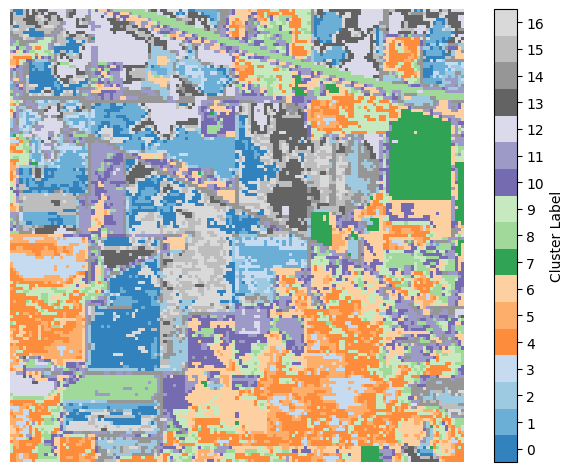

In [17]:
# bisecting k-means clustering using the selected components
bisecting_kmeans = cluster.BisectingKMeans(n_clusters=17, max_iter=248, random_state=1) # create an object of the classifier
labels = bisecting_kmeans.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

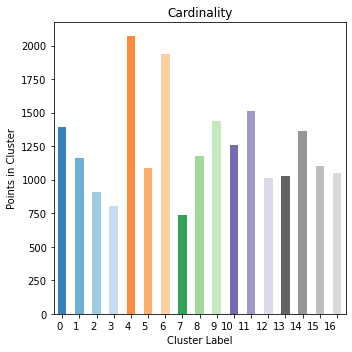

In [18]:
n_clusters = 16
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(bisecting_kmeans.labels_, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

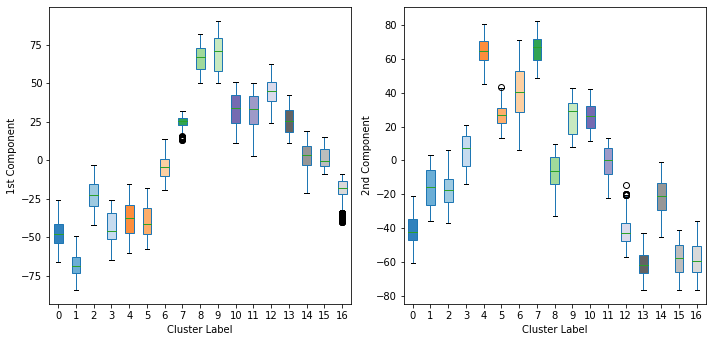

In [19]:
features = ['1st Component', '2nd Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = bisecting_kmeans.labels_

ncols = 2
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = selected_components_df[[feature, 'cluster']].boxplot(by='cluster', ax=ax, return_type='both', patch_artist=True)

    for row_key, (ax, row) in box.iteritems():
        ax.set_xlabel('Cluster Label')
        ax.set_title('')
        ax.set_ylabel(feature)
        ax.grid(False)
        
        for i, box_ in enumerate(row['boxes']):
            box_.set_facecolor(colors[i])

fig.suptitle('')
plt.tight_layout()
plt.show()

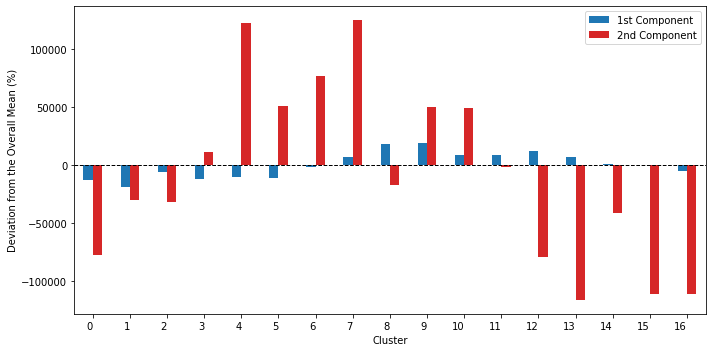

In [20]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_bisecting_kmeans = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.BisectingKMeans(n_clusters=n_clusters, max_iter=248, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_bisecting_kmeans.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_bisecting_kmeans.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.383083,22098.232724,0.850599,0.360409,0.247739,0.293637,0.699861,0.069034,0.658382,0.291899
16.0,0.376474,22613.761503,0.850930,0.364620,0.244459,0.292687,0.703015,0.073208,0.666073,0.290847
17.0,0.369553,22572.193673,0.887189,0.365907,0.239102,0.289216,0.705796,0.075604,0.668425,0.287272
18.0,0.365458,23337.237986,0.875295,0.368354,0.235332,0.287187,0.703584,0.063467,0.672894,0.285142
19.0,0.362697,23530.135634,0.886206,0.369204,0.230423,0.283753,0.703411,0.056980,0.674448,0.281606


# BIRCH

In [ ]:
# birch clustering using the selected components
birch = cluster.Birch(n_clusters=17) # create an object of the classifier

search_space = {
    'branching_factor': Integer(10, 100)
    }

bayes_search = BayesSearchCV(birch, search_space, n_iter=50, # specify how many iterations
                                scoring='v_measure_score', n_jobs=-1, verbose=1, random_state=1)

bayes_search.fit(selected_components, gt_reshaped) # callback=on_step will print score after each iteration

print('\n', bayes_search.best_estimator_)
print('\nBest V-measure:', bayes_search.best_score_)

# Best V-measure: 0.33059820941130014
# branching_factor=30

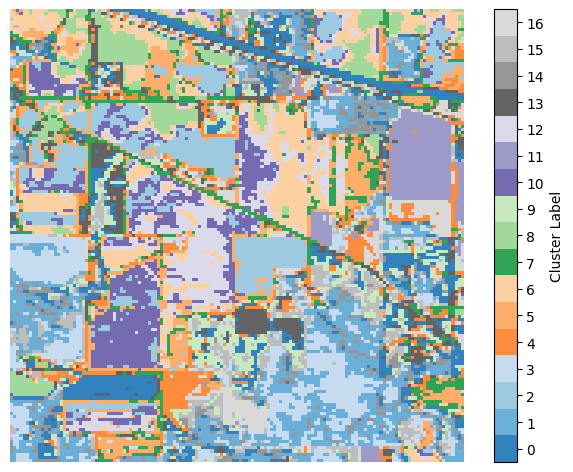

In [22]:
# birch clustering using the selected components
birch = cluster.Birch(n_clusters=17, branching_factor=30) # create an object of the classifier
labels = birch.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

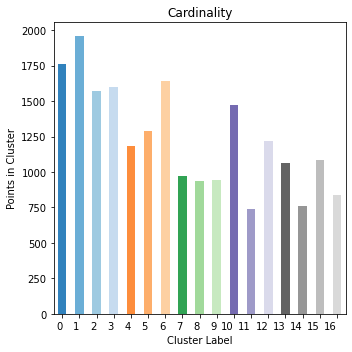

In [23]:
n_clusters = 16
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(birch.labels_, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

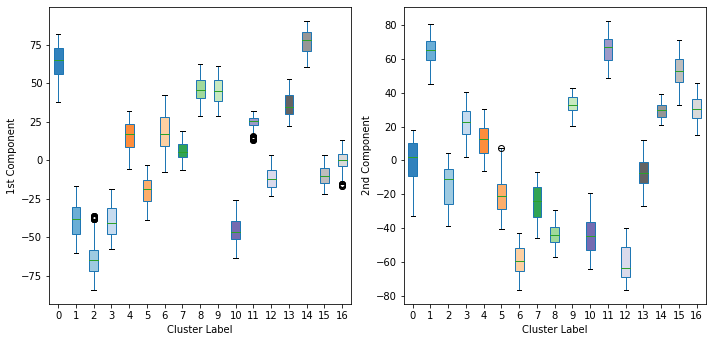

In [24]:
features = ['1st Component', '2nd Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = birch.labels_

ncols = 2
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = selected_components_df[[feature, 'cluster']].boxplot(by='cluster', ax=ax, return_type='both', patch_artist=True)

    for row_key, (ax, row) in box.iteritems():
        ax.set_xlabel('Cluster Label')
        ax.set_title('')
        ax.set_ylabel(feature)
        ax.grid(False)
        
        for i, box_ in enumerate(row['boxes']):
            box_.set_facecolor(colors[i])

fig.suptitle('')
plt.tight_layout()
plt.show()

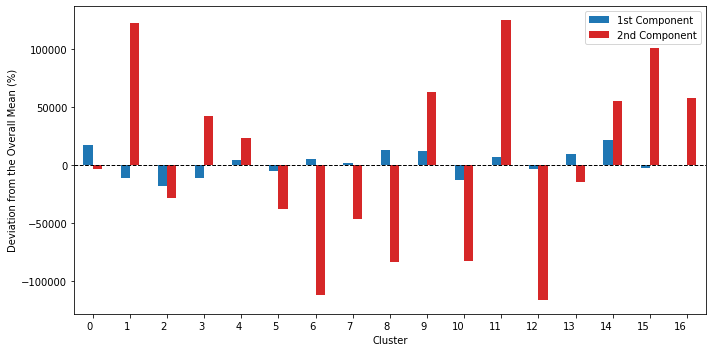

In [25]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_birch = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.Birch(n_clusters=n_clusters, branching_factor=30)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_birch.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_birch.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.397201,23532.051705,0.753344,0.374370,0.257563,0.305171,0.701119,0.073149,0.683885,0.303460
16.0,0.407544,24236.685918,0.776113,0.378160,0.253153,0.303280,0.702269,0.069887,0.690809,0.301470
17.0,0.403084,24609.124262,0.775742,0.379341,0.248238,0.300096,0.699926,0.057515,0.692965,0.298180
18.0,0.412426,25229.901340,0.779019,0.381602,0.244948,0.298372,0.699361,0.051769,0.697097,0.296354
19.0,0.406141,25251.908557,0.794454,0.382314,0.240079,0.294944,0.699261,0.046189,0.698397,0.292823


# Agglomerative Clustering

In [ ]:
# define the model
model = cluster.AgglomerativeClustering(n_clusters=17) # create an object of the classifier
# define the space of hyperparameters to search
search_space = [Categorical(['ward', 'complete', 'average', 'single'], name='linkage')]

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    # setting the parameters of the model
    model.set_params(**params)
    # fitting the model
    labels = model.fit_predict(selected_components)
    result= v_measure_score(gt_reshaped, labels)
    return 1.0 - result

# perform optimisation
result = gp_minimize(evaluate_model, search_space, n_jobs=-1, n_calls=50)
# summarising finding
print(f'Best V-measure: {1.0 - result.fun}')
print(f'Best Parameters: linkage = {result.x[0]}')

# Best V-measure: 0.3037501684672518
# Best Parameters: linkage = average

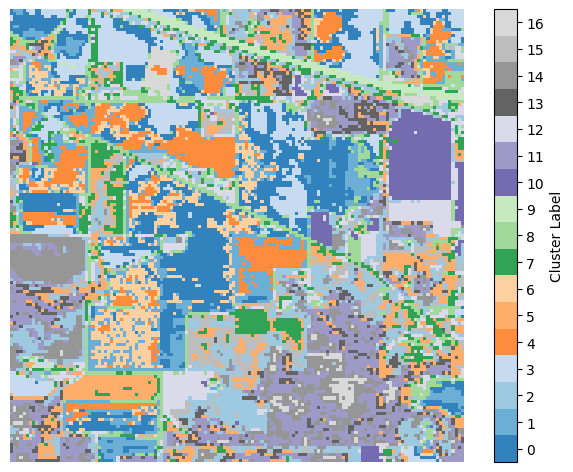

In [27]:
# agglomerative clustering using the selected components
agglomerative = cluster.AgglomerativeClustering(n_clusters=17, linkage='average') # create an object of the classifier
labels = agglomerative.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

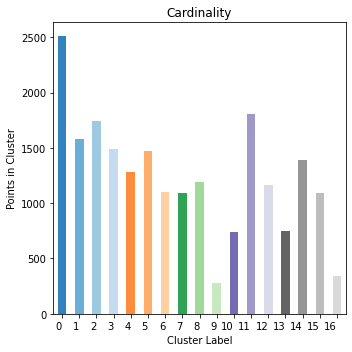

In [28]:
n_clusters = 16
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(agglomerative.labels_, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

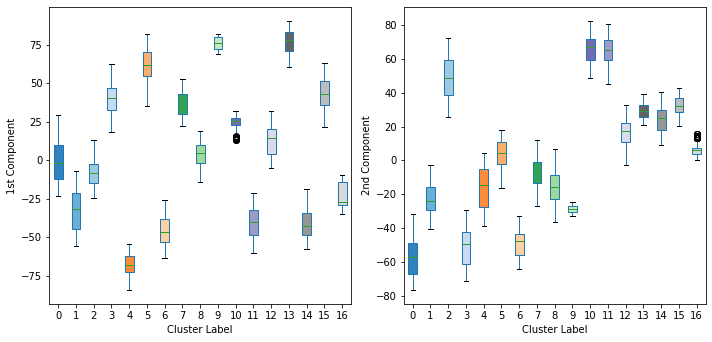

In [29]:
features = ['1st Component', '2nd Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = agglomerative.labels_

ncols = 2
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = selected_components_df[[feature, 'cluster']].boxplot(by='cluster', ax=ax, return_type='both', patch_artist=True)

    for row_key, (ax, row) in box.iteritems():
        ax.set_xlabel('Cluster Label')
        ax.set_title('')
        ax.set_ylabel(feature)
        ax.grid(False)
        
        for i, box_ in enumerate(row['boxes']):
            box_.set_facecolor(colors[i])

fig.suptitle('')
plt.tight_layout()
plt.show()

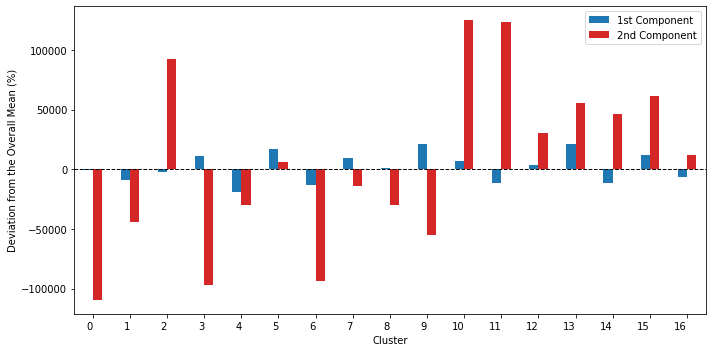

In [30]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [31]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_agglomerative = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_agglomerative.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_agglomerative.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.405196,23014.946906,0.712638,0.369171,0.258295,0.303937,0.696121,0.064121,0.674388,0.302209
16.0,0.423462,24354.152815,0.710835,0.374183,0.253732,0.302405,0.696458,0.056389,0.683544,0.300581
17.0,0.415769,24024.294808,0.718177,0.379266,0.253313,0.303750,0.697218,0.056105,0.692829,0.301825
18.0,0.406352,24799.451545,0.759204,0.381780,0.247575,0.300369,0.701319,0.060319,0.697421,0.298348
19.0,0.406171,24984.615144,0.786036,0.384118,0.244644,0.298912,0.703114,0.062585,0.701693,0.296789


# Gaussian Mixture

In [ ]:
# gaussian mixture clustering using the selected components
gaussian_mix = mixture.GaussianMixture(n_components=17) # create an object of the classifier

search_space = {
    'covariance_type': Categorical(['full', 'tied', 'diag', 'spherical']),
    'tol': Real(1e-5, 1e-2)
    }

bayes_search = BayesSearchCV(gaussian_mix, search_space, n_iter=50, # specify how many iterations
                             scoring='v_measure_score', n_jobs=-1, verbose=1, random_state=1)

bayes_search.fit(selected_components, gt_reshaped) # callback=on_step will print score after each iteration

print('\n', bayes_search.best_estimator_)
print('\nBest V-measure:', bayes_search.best_score_)

# Best V-measure: 0.33395473859899694
# Best Parameters: covariance_type = tied, tol=0.009992462954837572

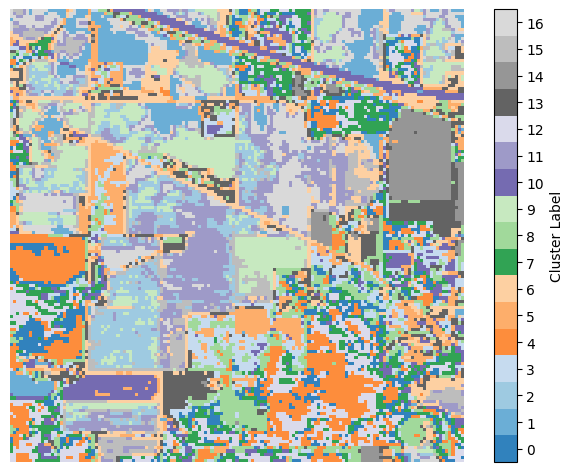

In [32]:
# gaussian mixure using the selected components
gaussian_mix = mixture.GaussianMixture(n_components=17, covariance_type='tied', tol=0.01, random_state=1) # create an object of the classifier
labels = gaussian_mix.fit_predict(selected_components)
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

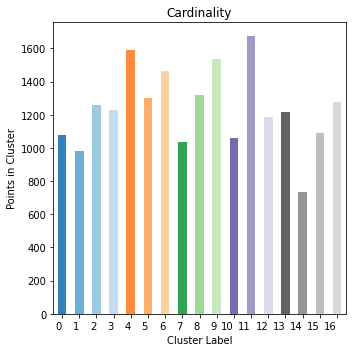

In [33]:
n_clusters = 16
colors = cm.tab20c([x/n_clusters for x in list(range(n_clusters+1))])

fig, ax = plt.subplots(figsize=(5, 5))
plot_cluster_cardinality(labels, ax=ax, title='Cardinality', color=colors)
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

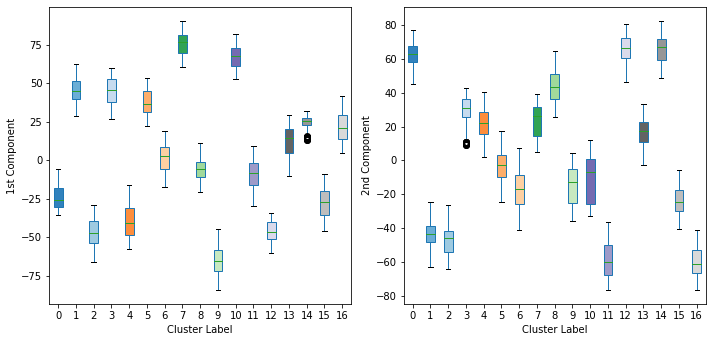

In [34]:
features = ['1st Component', '2nd Component']
selected_components_df = pd.DataFrame(selected_components, columns=features)
selected_components_df['cluster'] = labels

ncols = 2
nrows = len(features) // ncols + (len(features) % ncols > 0)

fig = plt.figure(figsize=(10, 5))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n+1)
    box = selected_components_df[[feature, 'cluster']].boxplot(by='cluster', ax=ax, return_type='both', patch_artist=True)

    for row_key, (ax, row) in box.iteritems():
        ax.set_xlabel('Cluster Label')
        ax.set_title('')
        ax.set_ylabel(feature)
        ax.grid(False)
        
        for i, box_ in enumerate(row['boxes']):
            box_.set_facecolor(colors[i])

fig.suptitle('')
plt.tight_layout()
plt.show()

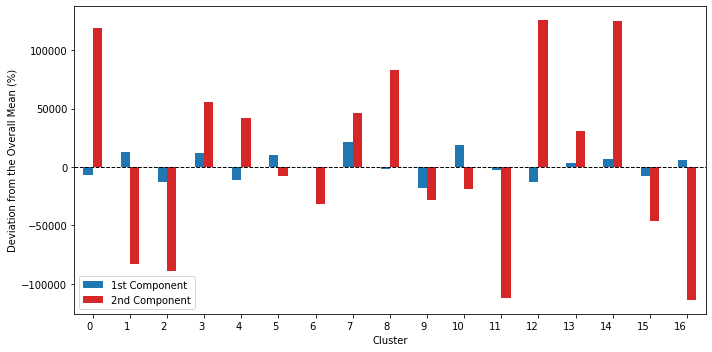

In [35]:
selected_components_mean = pd.concat([pd.DataFrame(selected_components_df.mean().drop('cluster'), columns=['mean']),
                                      selected_components_df.groupby('cluster').mean().T], axis=1)
selected_components_dev_rel = selected_components_mean.apply(lambda x: round((x-x['mean'])/x['mean'], 2)*100, axis=1)

selected_components_dev_rel.drop(columns=['mean'], inplace=True)
selected_components_mean.drop(columns=['mean'], inplace=True)

fig = plt.figure(figsize=(10, 5))

selected_components_dev_rel.T.plot(kind='bar',
                                   ax=fig.add_subplot(),
                                   color=['tab:blue', 'tab:red'],
                                   xlabel='Cluster',
                                   ylabel='Deviation from the Overall Mean (%)'
                                  )

plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(loc='best')
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [36]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_gaussian_mix = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialise the clusterer with n_clusters value and a random generator
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='tied', tol=0.01, random_state=1)
    labels = clusterer.fit_predict(selected_components)

    # the silhouette_score gives the average value for all the samples
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score
                   calinski_harabasz_score(selected_components, labels),
                   # the resulting Davies-Bouldin score
                   # the minimum score is zero, and the lower values the better clustering performance
                   davies_bouldin_score(selected_components, labels),
                   # homogeneity score between 0.0 and 1.0
                   # 1.0 stands for perfectly homogeneous labelling
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0
                   # 1.0 stands for perfectly complete labelling
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0
                   # random labellings have an ARI close to 0.0
                   # 1.0 stands for perfect match
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched)
                   # random partitions (independent labellings) have an expected AMI around 0 on average hence can be negative
                   # the value is in adjusted nats (based on the natural logarithm)
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_gaussian_mix.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_gaussian_mix.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.383734,23117.192763,0.821395,0.370530,0.254256,0.301573,0.699241,0.065924,0.676869,0.299857
16.0,0.427719,26219.408717,0.732056,0.382724,0.255072,0.306123,0.697754,0.054301,0.699145,0.304325
17.0,0.421448,27137.837030,0.749031,0.385646,0.250211,0.303505,0.701552,0.059032,0.704483,0.301608
18.0,0.419979,27211.250715,0.739618,0.392181,0.249734,0.305152,0.702733,0.059023,0.716421,0.303163
19.0,0.418691,27125.899058,0.746151,0.392206,0.245258,0.301795,0.701894,0.052902,0.716467,0.299700
